In [0]:
import torch
import pandas as pd 
from PIL import Image
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.datasets as datasets
import torchvision
import matplotlib.pyplot as plt
from torchvision import models
from torch.autograd import Variable
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
import torch.optim as optim
import torch.nn as nn
import numpy as np
import os

In [0]:
traindata = datasets.ImageFolder('/home/balaji/balaji/train', transforms.ToTensor())
image_means = torch.stack([t.mean(1).mean(1) for t, c in traindata])
std_means = torch.stack([t.std(1).std(1) for t, c in traindata])
print("Mean",image_means.mean(0))
print("Standard Deviation",std_means.std(0))

Mean tensor([0.4956, 0.5150, 0.5682])
Standard Deviation tensor([0.0238, 0.0246, 0.0224])


In [0]:
def vocabulary(labels):
    words=set()
    for i in labels:
        words.add(i)
    print(len(words))
    all_words=sorted(list(words))
    vocab={ all_words[j]:j for j in range(0,len(all_words)) }
    return vocab

In [0]:
data = pd.read_csv('train_cars.csv', sep=",")
X = np.asarray(data.iloc[:,0])
label_arr = np.asarray(data.iloc[:,1]) 
vocab = vocabulary(label_arr)
input_len=len(data.index)


words2=set()
for i in label_arr:
    words2.add(i)
print(len(words2))
all_words2=sorted(list(words2))
print(all_words2[11])

15
15
sedan


In [0]:
X_train, X_test,y_train,y_test = train_test_split(X,label_arr, test_size=0.1, random_state=10,stratify=label_arr)

In [0]:
unique, counts = np.unique(y_test, return_counts=True)
print(dict(zip(unique, counts)))

{'bus': 5, 'cement mixer': 2, 'crane truck': 2, 'hatchback': 308, 'jeep': 87, 'light truck': 16, 'minibus': 3, 'minivan': 59, 'pickup': 44, 'prime mover': 4, 'sedan': 578, 'truck': 18, 'van': 36}


In [0]:
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

{'bus': 48, 'cement mixer': 15, 'crane truck': 14, 'dedicated agricultural vehicle': 5, 'hatchback': 2772, 'jeep': 778, 'light truck': 148, 'minibus': 22, 'minivan': 527, 'pickup': 391, 'prime mover': 40, 'sedan': 5205, 'tanker': 3, 'truck': 161, 'van': 326}


In [0]:
data2 = pd.read_csv('train_cars.csv', sep=",")
print(data2.groupby(['target']).size())

target
bus                                 53
cement mixer                        17
crane truck                         16
dedicated agricultural vehicle       5
hatchback                         3080
jeep                               865
light truck                        164
minibus                             25
minivan                            586
pickup                             435
prime mover                         44
sedan                             5783
tanker                               3
truck                              179
van                                362
dtype: int64


In [0]:
train,valid=train_test_split(data2,test_size=0.1,random_state=10,stratify=data2.target)

In [0]:
print(valid.groupby(['target']).size())

target
bus               5
cement mixer      2
crane truck       2
hatchback       308
jeep             87
light truck      16
minibus           3
minivan          59
pickup           44
prime mover       4
sedan           578
truck            18
van              36
dtype: int64


In [0]:
class DriveData(Dataset):
    __xs = []
    __ys = []

    def __init__(self, csv_path,X_data,y_label, transform=None):
        
        self.transform = transform
        # Open and load text file including the whole training data

        #self.data = pd.read_csv(csv_path, sep=",")

        self.X_arr = X_data

        self.label_arr = y_label 

        #self.vocab = vocabulary(self.label_arr)

        self.input_len=len(self.X_arr)

    # Override to give PyTorch access to any image on the dataset
    def __getitem__(self, index):
        
        img = Image.open('train/'+self.X_arr[index])

        img = img.convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        # Convert image and label to torch tensors
        #img = self.to_tensor(img)
        label = self.label_arr[index]
        return img, vocab[label]

    # Override to give PyTorch size of dataset
    def __len__(self):
        return self.input_len

In [0]:
# define transforms
valid_transform = transforms.Compose([
        
        transforms.Resize((80,80)),
        transforms.ToTensor(),
        transforms.Normalize((0.4956,0.5150,0.5682),(0.0238,0.0246,0.0224)),
])
train_transform = transforms.Compose([
    transforms.Resize((80,80)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4956, 0.5150, 0.5682),(0.0238, 0.0246, 0.0224)),
])
#else:
 #   train_transform = transforms.Compose([
   #     transforms.ToTensor(),
  #      normalize,
  #  ])

# load the dataset

train_dataset = DriveData('train_cars.csv',X_train,y_train,train_transform)
valid_dataset = DriveData('train_cars.csv',X_test,y_test,valid_transform)
print(len(valid_dataset))

1162


In [0]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=64
)


#trainset = DriveData('train_cars.csv',transform)

print(train_dataset[3],train_dataset[3][0].shape)

(tensor([[[-20.8235, -20.8235, -20.8235,  ...,  -6.8179,  -6.9827,  -6.9827],
         [-20.8235, -20.8235, -20.8235,  ...,  -6.8179,  -6.9827,  -6.9827],
         [-20.8235, -20.8235, -20.8235,  ...,  -7.1475,  -7.1475,  -7.1475],
         ...,
         [ -5.1702,  -5.1702,  -5.0054,  ...,  -4.5111,  -3.6873,  -3.6873],
         [ -5.0054,  -5.0054,  -5.3350,  ...,  -4.8407,  -4.0168,  -4.0168],
         [ -5.0054,  -5.0054,  -5.3350,  ...,  -4.8407,  -4.0168,  -4.0168]],

        [[-20.9350, -20.9350, -20.9350,  ...,  -6.2689,  -6.4283,  -6.4283],
         [-20.9350, -20.9350, -20.9350,  ...,  -6.4283,  -6.4283,  -6.4283],
         [-20.9350, -20.9350, -20.9350,  ...,  -6.7472,  -6.5878,  -6.5878],
         ...,
         [ -4.6748,  -4.6748,  -4.5154,  ...,  -4.9936,  -4.0371,  -4.0371],
         [ -4.5154,  -4.5154,  -4.6748,  ...,  -5.1530,  -4.3560,  -4.3560],
         [ -4.5154,  -4.5154,  -4.6748,  ...,  -5.1530,  -4.3560,  -4.3560]],

        [[-25.3661, -25.3661, -25.3661,  ..

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 80, 80])
sedan minivan hatchback sedan


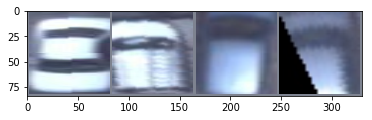

In [0]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(images.shape)
def imshow(img):
    img=img.numpy().transpose((1,2,0))
    mean=np.array([0.4956,0.5150,0.5682])
    std=[0.0238, 0.0246, 0.0224]
    img = std*img+mean     # unnormalize
    #npimg = img.numpy()
    #plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.imshow(img)
    
    
# show images
grid = torchvision.utils.make_grid(images[:4])
imshow(grid)
# print labels
print(' '.join('%5s' % all_words2[labels[j]] for j in range(4)))

In [0]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [0]:
import time
import copy
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [0]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.avgpool = nn.AdaptiveAvgPool2d(1)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size



In [0]:
# Initialize the model for this run
model_ft, input_size = initialize_model('resnet', 15, False, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
feature_extract=False
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

In [0]:
dataloaders=dict()
dataloaders['train']=train_loader
dataloaders['val']=valid_loader

In [0]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=20)

Epoch 0/19
----------
train Loss: 1.2806 Acc: 0.5747
val Loss: 1.0391 Acc: 0.6540

Epoch 1/19
----------
train Loss: 0.9390 Acc: 0.6736
val Loss: 0.9381 Acc: 0.6704

Epoch 2/19
----------
train Loss: 0.8227 Acc: 0.7103
val Loss: 0.8864 Acc: 0.6893

Epoch 3/19
----------
train Loss: 0.7424 Acc: 0.7376
val Loss: 0.8533 Acc: 0.7022

Epoch 4/19
----------
train Loss: 0.6745 Acc: 0.7593
val Loss: 0.8719 Acc: 0.7040

Epoch 5/19
----------
train Loss: 0.6100 Acc: 0.7842
val Loss: 0.8657 Acc: 0.7074

Epoch 6/19
----------
train Loss: 0.5524 Acc: 0.8083
val Loss: 0.8733 Acc: 0.6936

Epoch 7/19
----------
train Loss: 0.4912 Acc: 0.8311
val Loss: 0.8929 Acc: 0.7108

Epoch 8/19
----------
train Loss: 0.4274 Acc: 0.8535
val Loss: 0.9276 Acc: 0.7212

Epoch 9/19
----------
train Loss: 0.3992 Acc: 0.8679
val Loss: 0.9576 Acc: 0.6962

Epoch 10/19
----------
train Loss: 0.3471 Acc: 0.8862
val Loss: 0.9680 Acc: 0.7022

Epoch 11/19
----------
train Loss: 0.3061 Acc: 0.8986
val Loss: 1.0352 Acc: 0.7074

Ep

In [0]:
print(hist)

[tensor(0.6540, device='cuda:0', dtype=torch.float64), tensor(0.6704, device='cuda:0', dtype=torch.float64), tensor(0.6893, device='cuda:0', dtype=torch.float64), tensor(0.7022, device='cuda:0', dtype=torch.float64), tensor(0.7040, device='cuda:0', dtype=torch.float64), tensor(0.7074, device='cuda:0', dtype=torch.float64), tensor(0.6936, device='cuda:0', dtype=torch.float64), tensor(0.7108, device='cuda:0', dtype=torch.float64), tensor(0.7212, device='cuda:0', dtype=torch.float64), tensor(0.6962, device='cuda:0', dtype=torch.float64), tensor(0.7022, device='cuda:0', dtype=torch.float64), tensor(0.7074, device='cuda:0', dtype=torch.float64), tensor(0.7143, device='cuda:0', dtype=torch.float64), tensor(0.7229, device='cuda:0', dtype=torch.float64), tensor(0.7083, device='cuda:0', dtype=torch.float64), tensor(0.7100, device='cuda:0', dtype=torch.float64), tensor(0.7108, device='cuda:0', dtype=torch.float64), tensor(0.6919, device='cuda:0', dtype=torch.float64), tensor(0.7160, device='cuda